# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [85]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [86]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       dog       bird      plane        car


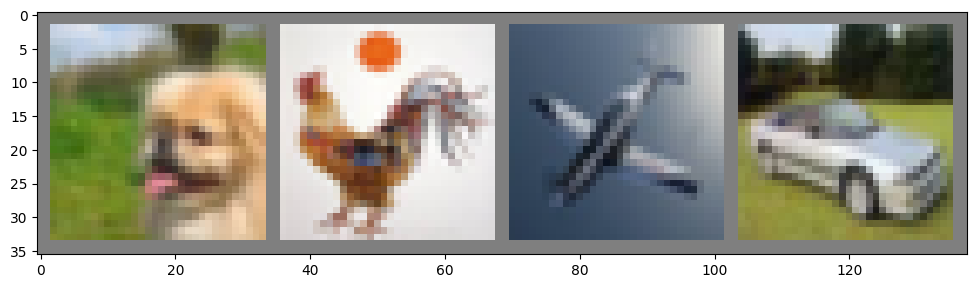

In [87]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
device = "cpu"

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        # self.conv_dropout = nn.Dropout2d(p=0.05)
        self.pool1 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(3*3*128, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        #x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        # x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        #x = self.conv_dropout(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

criterion = None
optimizer = None

model = Net().to(device)
model.cpu()
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# summary(model, (3, 32, 32))
print('done')

done


In [121]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item()}')

    print(f'[{epoch + 1}, DONE] running loss: {running_loss}')


print('Finished Training')
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

[1,     2] loss: 1.1027393341064453
[1,     3] loss: 1.0351405143737793
[1,     4] loss: 0.992152214050293
[1,     5] loss: 1.0159584283828735
[1,     6] loss: 0.912821352481842
[1,     7] loss: 0.9768838882446289
[1,     8] loss: 1.1376699209213257
[1,     9] loss: 0.9379281997680664
[1,    10] loss: 1.0888980627059937
[1,    11] loss: 1.0107057094573975
[1,    12] loss: 0.9496291875839233
[1,    13] loss: 1.1839872598648071
[1,    14] loss: 0.9030840396881104
[1,    15] loss: 1.035497784614563
[1,    16] loss: 1.0524853467941284
[1,    17] loss: 1.2099496126174927
[1,    18] loss: 0.8487626314163208
[1,    19] loss: 1.0926682949066162
[1,    20] loss: 0.8056471347808838
[1,    21] loss: 0.761736273765564
[1,    22] loss: 1.1486942768096924
[1,    23] loss: 1.0800867080688477
[1,    24] loss: 0.8873189687728882
[1,    25] loss: 1.1818122863769531
[1,    26] loss: 0.9236692190170288
[1,    27] loss: 0.8604266047477722
[1,    28] loss: 1.053999900817871
[1,    29] loss: 0.90634882450103

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [123]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
correct = 0
total = 0


# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Set the confusion matrix values

        for i in range(10):
            p_idx = predicted[i]
            gt_idx = labels[i]
            confusion_matrix[gt_idx][p_idx]+=1



model_accuracy = (correct / total) * 100
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 71.84%


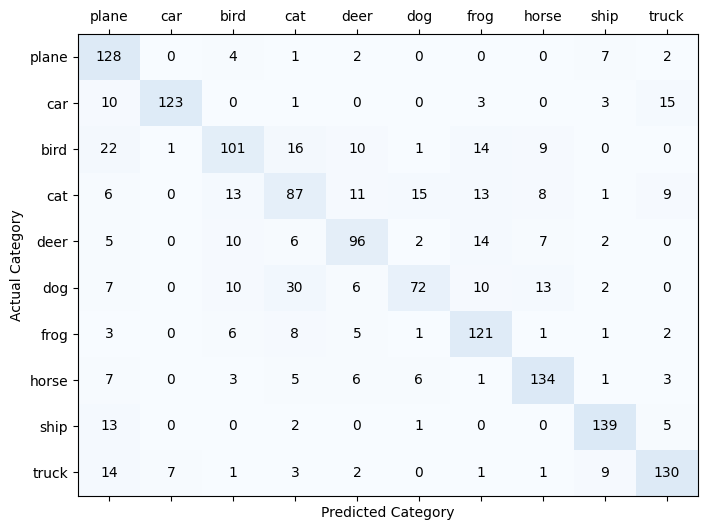

In [124]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, int(z), ha='center', va='center')

plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** *Fill this in*
Here are some of the things I've experimented with:
1. Adding more convolution filters to the same layer, and it seemed to be helpful.
Why? - I assume it allows the network to learn more patterns. <br><br>
2. Adding more convolution layers (Worked up to a certain point, and the model was too slow for the train step).
Why? - Adding each layer got a performance cost for the gradient convergence, and it seems like just going to deeper layer without adding anything else is won't do well. <br><br>
3. Adding dropout - Didn't have the desired effect test accuracy got lower.
Why? - Overfitting difference between train and test wasn't that much and the dropout made it a lot harder to converge on several epochs. <br><br>

4. Testing different feature sizes for the fully connected layers - Probably not as helpful as the convolution layers.
Why? - I assume due to parameter sharing convolution layers got better impact in learning patterns than adding more neurons to the FC layer. <br><br>

5. Reducing the input size with padding=0 or no max pool just directly flatten and linear (didn't do well, max pool and pad mode same worked better).
Why? - max pooling added more non-linearity to the model allowing it to learn more patterns. <br><br>

I've also experienced with changing the
 (SGD, Adam), Learning rate and other stuff.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *Fill this in*
While accuracy (the main diagonal of the confusion matrix) is important it's not everything. <br>
Depending on the use case we will usually need additional information. <br>
Examples: <br>
1. Maybe we give more weight to errors on one class more than others? <br>
2. Maybe we want to know the error per class distribution? <br>
3. Perhaps we would like metrics per class? accuracy per class? f-score per class? confusion matrix per class (binary)? <br>


# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [17]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [18]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [19]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(dataset_sizes)

{'train': 636, 'val': 158}


In [20]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

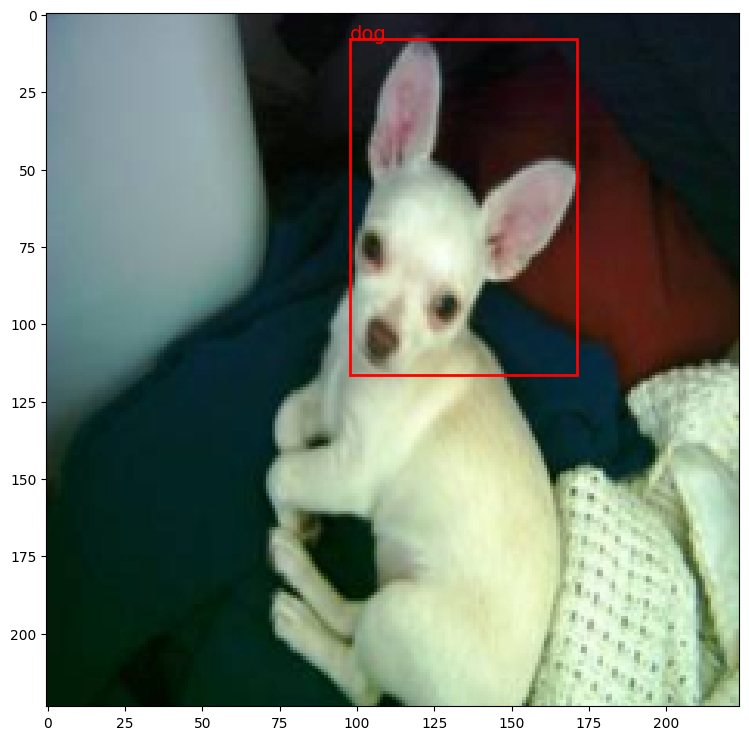

In [21]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        self.num_classes = num_classes
        self.backbone = resnet18

        # freeze all ResNet layers no need to train them
        for child in self.backbone.children():
            for param in child.parameters():
                param.requires_grad = False

        # build a new sequential model without the top FC layer
        resnet18_layers = list(self.backbone.children())[:-2]
        self.model = nn.Sequential(*resnet18_layers)

        # build the regressor head for outputting the bounding box
        self.regressor = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()
        )

        # build the classifier head to predict the class labels
        self.classifier = nn.Sequential(
            nn.Linear(7, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, self.num_classes)
        )

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        # pass the inputs through the base model and then obtain
        # predictions from two different branches of the network
        features = self.model(images)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
        # return the outputs as a tuple
        return (bboxes, classLogits)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = CNN(10).to(device)
summary(net, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
├─ResNet: 1                              []                        --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 64, 112, 112]        (recursive)
├─ResNet: 1                              []                        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 112, 112]        (128)
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-4                  [-1, 64, 112, 112]        (recursive)
├─ResNet: 1                              []                        --
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-6                         [-1, 64, 112, 112]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
├─ResNet: 1                              []                        --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 64, 112, 112]        (recursive)
├─ResNet: 1                              []                        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 112, 112]        (128)
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-4                  [-1, 64, 112, 112]        (recursive)
├─ResNet: 1                              []                        --
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-6                         [-1, 64, 112, 112]

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [51]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                # get the inputs; data is a list of [inputs, labels]
                images, labels, bbox = sample['image'].to(device), sample['label'].to(device), sample['bbox'].to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                label_pred, bbox_pred = model(images)

                loss_labels = criterion_cls(label_pred, labels)
                loss_bbox = criterion_bbox(bbox_pred, bbox)
                total_loss = loss_labels+loss_bbox
                total_loss.backward()
                optimizer.step()

                running_loss += total_loss
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [54]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
train_model(cnn, criterion_cls, criterion_bbox, optimizer)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch 1/5
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB (GPU 0; 4.00 GiB total capacity; 3.23 GiB already allocated; 0 bytes free; 3.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

In [125]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

NameError: name 'best_model' is not defined

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.